In [93]:
#imports
from ucimlrepo import fetch_ucirepo
from interpret import show
from interpret.data import Marginal
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, HistGradientBoostingRegressor
from scipy.cluster import hierarchy
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from fancyimpute import IterativeImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, make_scorer, f1_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, StandardScaler, MinMaxScaler, OneHotEncoder, scale
import matplotlib
from distutils.version import LooseVersion
from scipy.stats import chi2_contingency, f_oneway
from imblearn.combine import SMOTETomek
from collections import Counter
import pandas as pd
from sklearn.impute import SimpleImputer






from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
import seaborn as sns

# DATA

In [94]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878)

# data (as pandas dataframes)
X = cirrhosis_patient_survival_prediction.data.original
y = cirrhosis_patient_survival_prediction.data.targets

In [95]:
df = pd.DataFrame(X,  cirrhosis_patient_survival_prediction.original)
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174,10.9,3.0
414,415,1103,C,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180,11.2,4.0
415,416,1055,C,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143,9.9,3.0
416,417,691,C,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269,10.4,3.0


In [96]:
# Imprimir los nombres de todas las columnas
print(len(df.columns.tolist()))
print(df.columns.tolist())

20
['ID', 'N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


# ANÀLISIS I PREPROCESSAT DE DADES

### Analisi estadıstic de les variables de manera independent (previ)

Comentaris i discusso sobre els resultats. 1 Taula (mean, var, min, max, ...) + 1 Figura (distrib.) per variable

#### CATEGORICAS I BINARIAS

In [97]:
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
print('Number of categorical and binaria variables: ', len(cat_features))
print('*'*80)
print('Categorical variables column name:',cat_features)
df[cat_features]

Number of categorical and binaria variables:  11
********************************************************************************
Categorical variables column name: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']


,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Cholesterol,Copper,Tryglicerides,Platelets
0,D,D-penicillamine,F,Y,Y,Y,Y,261,156,172,190
1,C,D-penicillamine,F,N,Y,Y,N,302,54,88,221
2,D,D-penicillamine,M,N,N,N,S,176,210,55,151
3,D,D-penicillamine,F,N,Y,Y,S,244,64,92,183
4,CL,Placebo,F,N,Y,Y,N,279,143,72,136
...,...,...,...,...,...,...,...,...,...,...,...
413,D,NaN,F,NaN,NaN,NaN,N,NaN,NaN,NaN,174
414,C,NaN,F,NaN,NaN,NaN,N,NaN,NaN,NaN,180
415,C,NaN,F,NaN,NaN,NaN,N,NaN,NaN,NaN,143
416,C,NaN,F,NaN,NaN,NaN,N,NaN,NaN,NaN,269


In [98]:
fake_cat = ["Cholesterol", "Copper", "Tryglicerides", "Platelets"]
for i in fake_cat:
    print(f"{i} es: {type(df[cat_features][i][0])}")


Cholesterol es: <class 'str'>
Copper es: <class 'str'>
Tryglicerides es: <class 'str'>
Platelets es: <class 'str'>


In [99]:
# Convirtiendo cada columna a numérico
for columna in fake_cat:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')  # errors='coerce' si no pots fer NA

In [100]:
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
print('Number of categorical and binaria variables: ', len(cat_features))
print('*'*80)
print('Categorical variables column name:', cat_features)



Number of categorical and binaria variables:  7
********************************************************************************
Categorical variables column name: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [101]:
import plotly.express as px

for feature in cat_features:
    # Calculamos el conteo y el porcentaje para cada categoría
    df_count = df[feature].value_counts().reset_index()
    df_count.columns = [feature, 'count']
    df_count['percent'] = 100 * df_count['count'] / df_count['count'].sum()

    # Creamos la gráfica de barras con colores distintos para cada categoría
    fig = px.bar(df_count, x=feature, y='count', text='percent', color=feature)

    # Actualizamos el layout para añadir título y etiquetas
    fig.update_layout(
        title=f'Distribución de la variable {feature}',
        xaxis_title=feature,
        yaxis_title='Conteo'
    )

    # Añadir el porcentaje en las barras
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

    fig.show()

#### NUMERQIEUS

In [102]:
numerical_features = [
    feature for feature in df.columns if df[feature].dtypes != 'O']
print('Number of numerical variables: ', len(numerical_features))
print('*'*80)
print('Numerical Variables Column: ', numerical_features)
df[numerical_features]

Number of numerical variables:  13
********************************************************************************
Numerical Variables Column:  ['ID', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,24472,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,14245,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,20819,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,21185,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [103]:
df.drop("ID", axis=1, inplace=True)

In [104]:
# Seleccionamos solo las columnas numéricas
numerical_columns = df.select_dtypes(include=['number'])

# Generamos la tabla de estadísticas descriptivas
statistics_table = numerical_columns.describe()

# Imprimimos la tabla
statistics_table.describe().round(2)

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00
mean,1714.09,14570.02,57.44,467.43,54.88,165.31,2837.12,165.26,180.76,287.86,60.81,53.74
std,1491.85,9389.60,145.97,535.34,146.73,193.56,4515.53,146.19,184.46,207.65,143.59,144.76
min,41.00,418.00,0.30,120.00,0.42,4.00,289.00,26.35,33.00,62.00,1.02,0.88
25%,924.06,8152.46,1.25,245.11,2.92,65.06,731.62,74.62,79.47,165.96,9.75,1.75
50%,1417.34,17088.93,3.31,296.75,3.51,91.63,1619.50,118.63,116.35,254.01,10.67,3.01
75%,2091.71,19289.12,10.31,377.13,3.99,169.75,2022.09,191.92,183.75,340.25,12.82,4.00
max,4795.00,28650.00,418.00,1775.00,418.00,588.00,13862.40,457.25,598.00,721.00,416.00,412.00


In [105]:
import plotly.graph_objects as go
import plotly.express as px

import plotly.express as px



for feature in numerical_columns:
    # Histograma
    fig = px.histogram(df, x=feature, marginal="box",
                       title=f'Histograma de {feature}')
    fig.update_layout(xaxis_title=feature, yaxis_title='Conteo')
    fig.show()

### Estudi de balanceig de classes

1 Figura (histograma amb freq. per classe). En aquest punt, decidim si fem servir algun metode per balanceig de classes. Justificar aquesta decisio i detallar les consequencies.

In [106]:
df['Status'].value_counts()

Status
C     232
D     161
CL     25
Name: count, dtype: int64

### Missings

Identificacio i proposta de gestio. 1 Taula (num. misings per var). Si es fa imputacio cal fer-ho despres del particionat de dades.

In [107]:
for feature in numerical_columns:
    # Calculem el nombre de valors absents
    missing_count = df[feature].isnull().sum()
    # Calculem el percentatge de valors absents
    missing_percentage = (missing_count / len(df)) * 100

    if missing_count > 0:
        print(
            f"La variable {feature} té {missing_count} valors absents, el que representa un {missing_percentage:.2f}%.")
    else:
        print(f"La variable {feature} no té valors absents.")

La variable N_Days no té valors absents.
La variable Age no té valors absents.
La variable Bilirubin no té valors absents.
La variable Cholesterol té 134 valors absents, el que representa un 32.06%.
La variable Albumin no té valors absents.
La variable Copper té 108 valors absents, el que representa un 25.84%.
La variable Alk_Phos té 106 valors absents, el que representa un 25.36%.
La variable SGOT té 106 valors absents, el que representa un 25.36%.
La variable Tryglicerides té 136 valors absents, el que representa un 32.54%.
La variable Platelets té 11 valors absents, el que representa un 2.63%.
La variable Prothrombin té 2 valors absents, el que representa un 0.48%.
La variable Stage té 6 valors absents, el que representa un 1.44%.


### Outliers

Identificacio i proposta de gestio, si cal. 1 Figura per variable amb outliers amb la distribucio amb i sense outlier.

In [108]:

# Calcula el valor màxim i mínim de la columna "Age" i després divideix-los per 365
edat_maxima = df["Age"].max() / 365
edat_minima = df["Age"].min() / 365

print(f"Edat màxima en anys: {edat_maxima:.2f} anys")
print(f"Edat mínima en anys: {edat_minima:.2f} anys")



Edat màxima en anys: 78.49 anys
Edat mínima en anys: 26.30 anys


In [109]:
# Calcula el valor màxim i mínim de la columna "Age" i després divideix-los per 365
edat_maxima = df["N_Days"].max() / 365
edat_minima = df["N_Days"].min() / 365

print(f"N_Days màxima en anys: {edat_maxima:.2f} anys")
print(f"N_Days mínima en anys: {edat_minima:.2f} anys")

N_Days màxima en anys: 13.14 anys
N_Days mínima en anys: 0.11 anys


Totes les variables categoriques i booleanes no presenten ningun tipo de outlier, ja que els seus valors compleixen els citeris  de estipulats de "UC Irvine Machine Learning Repository".

Per altre banda, tant Age, com N_Days tambe son valors reals, ja que el seu rang de anys es 

## Feature engineering

### Construction

In [110]:
# Convertir els valors "Y" i "N" a 1 i 0 respectivament
df['Ascites'] = df['Ascites'].map({'Y': 1, 'N': 0})
df['Hepatomegaly'] = df['Hepatomegaly'].map({'Y': 1, 'N': 0})
df['Spiders'] = df['Spiders'].map({'Y': 1, 'N': 0})

# Crear un nou atribut que és la suma dels tres
df['Physical_Symptoms_Score'] = df['Ascites'] + df['Hepatomegaly'] + df['Spiders']


### Selection

In [111]:
# Eliminar 'N_Days', 'Ascites', 'Hepatomegaly', 'Spiders' ja que no aporten informacio.
df = df.drop(['N_Days', 'Ascites', 'Hepatomegaly', 'Spiders'], axis=1)

In [112]:
df.head()

,Status,Drug,Age,Sex,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Physical_Symptoms_Score
0,D,D-penicillamine,21464,F,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,3.0
1,C,D-penicillamine,20617,F,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,2.0
2,D,D-penicillamine,25594,M,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,0.0
3,D,D-penicillamine,19994,F,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,2.0
4,CL,Placebo,13918,F,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,2.0


In [113]:
# Conversió de l'edat de dies a anys
df['Age'] = df['Age'] / 365.25

## Mesclar

In [114]:
df_shuffled = shuffle(df, random_state=2)

## Particio del dataset

In [115]:
# Suposant que df és el teu DataFrame i 'Status' és la variable objectiu
X = df.drop('Status', axis=1)  # Totes les característiques excepte la variable objectiu
y = df['Status']  # La variable objectiu

# Dividir les dades en conjunts de trenament i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [116]:
y_test

414    C
82     C
106    C
198    C
97     C
      ..
211    C
398    C
163    D
150    C
19     D
Name: Status, Length: 84, dtype: object

## Tractament de missings

In [117]:
# Funció per autoimputar missings de manera controlada

def autoimpute_missing_values(data, missing_rate=0.1):
    df_missing = data.copy()
    for col in df_missing.columns:
        missing_indices = np.random.choice(df_missing.index, int(
            len(df_missing) * missing_rate), replace=False)
        df_missing.loc[missing_indices, col] = np.nan
    return df_missing


# Autoimputem missings
df_missing = autoimpute_missing_values(df)

In [118]:

# Crear una còpia del dataframe amb només columnes numèriques
numeric_cols = df_missing.select_dtypes(include=[np.number]).columns
df_missing_numeric = df_missing[numeric_cols]

# Funció per imputar valors numèrics amb RandomForest o HistGradientBoosting


def impute_numeric(data, cols, model_type='random_forest'):
    imputed_data = data.copy()
    for col in cols:
        # Comprova si hi ha files per imputar
        if imputed_data[col].isnull().sum() > 0:
            # Preparació del conjunt de dades
            train = imputed_data[imputed_data[col].notnull()]
            test = imputed_data[imputed_data[col].isnull()]
            y_train = train[col]
            X_train = train.drop(col, axis=1)
            X_test = test.drop(col, axis=1)

            # Omplir valors NaNs en X_train i X_test
            imputer = SimpleImputer(strategy='mean')
            X_train_imputed = imputer.fit_transform(X_train)
            X_test_imputed = imputer.transform(X_test)

            # Imputació amb el model seleccionat
            if model_type == 'random_forest':
                model = RandomForestRegressor(n_estimators=100)
            else:  # HistGradientBoosting
                model = HistGradientBoostingRegressor()

            model.fit(X_train_imputed, y_train)
            imputed_values = model.predict(X_test_imputed)

            # Assignació dels valors imputats
            imputed_data.loc[imputed_data[col].isnull(), col] = imputed_values


    return imputed_data



# Imputació amb RandomForest o HistGradientBoosting
df_numeric_rf = impute_numeric(df_missing_numeric, numeric_cols, model_type='random_forest')


# Imputació amb MICE
mice_imputer = IterativeImputer()
df_numeric_mice = df_missing_numeric.copy()
imputed_data = mice_imputer.fit_transform(df_missing_numeric)

df_numeric_mice_imputed = pd.DataFrame(imputed_data, columns=df_missing_numeric.columns, index=df_missing_numeric.index)

In [119]:

# Separació de les variables categòriques
categorical_cols = df_missing.select_dtypes(include=['object']).columns
df_missing_categorical = df_missing[categorical_cols]
df_missing_categorical = df_missing_categorical.replace('NaNN', np.nan)

# Funció per imputar valors categòrics


def impute_categorical(data, cols, method='most_frequent'):
    imputed_data = data.copy()
    for col in cols:
        imputer = SimpleImputer(strategy=method)
        imputed_data[col] = imputer.fit_transform(
            data[[col]]).ravel()  # Convertir en array 1D
    return imputed_data

# Funció per a Hot-Deck Imputation


def hot_deck_imputation(data, cols):
    imputed_data = data.copy()
    for col in cols:
        missing = imputed_data[col].isna()
        if missing.any():
            complete_mask = ~missing
            missing_mask = missing
            imputed_data.loc[missing_mask, col] = imputed_data.loc[complete_mask, col].sample(
                n=missing.sum(), replace=True).values
    return imputed_data


# Imputació amb Moda
df_categorical_mode = impute_categorical(df_missing_categorical, categorical_cols, method='most_frequent')

# Imputació amb Hot-Deck
df_categorical_hot_deck = hot_deck_imputation(df_missing_categorical, categorical_cols)

In [120]:

def calculate_mse(original_data, imputed_data, cols):
    mse_scores = {}
    for col in cols:
        # Comparar només les files on original_data no té NaNs
        mask = original_data[col].notna()
        mse_scores[col] = mean_squared_error(original_data.loc[mask, col], imputed_data.loc[mask, col])
    return mse_scores


def calculate_accuracy(original_data, imputed_data, cols):
    accuracy_scores = {}
    for col in cols:
        # Reindexa imputed_data per coincidir amb original_data
        imputed_col = imputed_data[col].reindex(original_data.index)
        # Només compara on original_data no té NaN
        mask = original_data[col].notna()
        correct = original_data.loc[mask, col] == imputed_col.loc[mask]
        # Utilitza mean() per calcular la precisió
        accuracy_scores[col] = correct.mean()
    return accuracy_scores

In [121]:
# Avaluar imputacions numèriques
mse_rf = calculate_mse(df[numeric_cols], df_numeric_rf, numeric_cols)
mse_mice = calculate_mse(df[numeric_cols], df_numeric_mice_imputed, numeric_cols)

# Comparar i determinar el millor mètode numèric
best_numeric_method = "Random Forest" if np.mean(list(mse_rf.values())) < np.mean(list(mse_mice.values())) else "MICE"

accuracy_mode = calculate_accuracy(df[categorical_cols], df_categorical_mode, categorical_cols)
accuracy_hot_deck = calculate_accuracy(df[categorical_cols], df_categorical_hot_deck, categorical_cols)


best_categorical_method = "Moda" if np.mean(list(accuracy_mode.values())) > np.mean(list(accuracy_hot_deck.values())) else "Hot-Deck"

print(f"El millor mètode per a dades numèriques és: {best_numeric_method}")
print(f"El millor mètode per a dades categòriques és: {best_categorical_method}")




El millor mètode per a dades numèriques és: MICE
El millor mètode per a dades categòriques és: Moda


In [122]:
# Suposem que X_train és el teu dataframe
# Separa les dades numèriques i categòriques

# Separa les dades numèriques i categòriques per X_train
numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns
categorical_cols_train = X_train.select_dtypes(include=['object', 'category']).columns

# Separa les dades numèriques i categòriques per X_test
numeric_cols_test = X_test.select_dtypes(include=[np.number]).columns
categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns

df_numeric_train = X_train[numeric_cols_train]
df_categorical_train = X_train[categorical_cols_train].replace('NaNN', np.nan)

df_numeric_test = X_test[numeric_cols_test]
df_categorical_test = X_test[categorical_cols_test].replace('NaNN', np.nan)

# Utilitza la funció impute_numeric que has definit abans per X_train
df_numeric_train_imputed = impute_numeric(df_numeric_train, numeric_cols_train, model_type='random_forest')

# Utilitza la mateixa funció impute_numeric per X_test
df_numeric_test_imputed = impute_numeric(df_numeric_test, numeric_cols_test, model_type='random_forest')

# Utilitza la funció hot_deck_imputation que has definit abans per X_train
df_categorical_train_imputed = hot_deck_imputation(df_categorical_train, categorical_cols_train)

# Utilitza la mateixa funció hot_deck_imputation per X_test
df_categorical_test_imputed = hot_deck_imputation(df_categorical_test, categorical_cols_test)

# Uneix les dades numèriques i categòriques imputades per X_train
X_train_imputed = pd.concat([df_numeric_train_imputed, df_categorical_train_imputed], axis=1)

# Uneix les dades numèriques i categòriques imputades per X_test
X_test_imputed = pd.concat([df_numeric_test_imputed, df_categorical_test_imputed], axis=1)

In [123]:
# Calcula els missings per a cada columna abans del preprocessament
missings_before_train = X_train.isna().sum()
missings_before_test = X_test.isna().sum()

# Calcula els missings per a cada columna després del preprocessament
missings_after_train = X_train_imputed.isna().sum()
missings_after_test = X_test_imputed.isna().sum()

# Imprimeix els resultats
print("Missings abans del preprocessament en X_train:")
print(missings_before_train)
print("\nMissings després del preprocessament en X_train:")
print(missings_after_train)

print("\nMissings abans del preprocessament en X_test:")
print(missings_before_test)
print("\nMissings després del preprocessament en X_test:")
print(missings_after_test)

Missings abans del preprocessament en X_train:
Drug                        87
Age                          0
Sex                          0
Edema                        0
Bilirubin                    0
Cholesterol                109
Albumin                      0
Copper                      89
Alk_Phos                    88
SGOT                        88
Tryglicerides              110
Platelets                    9
Prothrombin                  2
Stage                        3
Physical_Symptoms_Score     88
dtype: int64

Missings després del preprocessament en X_train:
Age                        0
Bilirubin                  0
Cholesterol                0
Albumin                    0
Copper                     0
Alk_Phos                   0
SGOT                       0
Tryglicerides              0
Platelets                  0
Prothrombin                0
Stage                      0
Physical_Symptoms_Score    0
Drug                       0
Sex                        0
Edema              

## Tractament de balanceig 

In [124]:


# Crear una instància de OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='if_binary')

# Ajustar i transformar les variables categòriques
X_train_categorical = X_train_imputed.select_dtypes(include=['object', 'category'])
encoder.fit(X_train_categorical)
X_train_categorical_encoded = encoder.transform(X_train_categorical)

# Crear un DataFrame amb les variables categòriques codificades
X_train_categorical_encoded_df = pd.DataFrame(X_train_categorical_encoded, 
                                              columns=encoder.get_feature_names_out(X_train_categorical.columns),
                                              index=X_train_categorical.index)


# Crear una instància de SMOTETomek
smote_tomek = SMOTETomek(random_state=0)


# Concatenar les variables numèriques amb les categòriques codificades
X_train_encoded = pd.concat([X_train_imputed.select_dtypes(include=[np.number]), 
                             X_train_categorical_encoded_df], axis=1)


# Aplicar SMOTETomek al conjunt de dades completament codificat
X_train_balanced_encoded, y_train_balanced = smote_tomek.fit_resample(X_train_encoded, y_train)


# Invertir la codificació one-hot per tornar a les variables categòriques originals
X_train_balanced_categorical = X_train_balanced_encoded[encoder.get_feature_names_out(X_train_categorical.columns)]
X_train_balanced_categorical = encoder.inverse_transform(X_train_balanced_categorical)

# Crear un DataFrame amb les variables categòriques retransformades
X_train_balanced_categorical_df = pd.DataFrame(X_train_balanced_categorical, 
                                               columns=X_train_categorical.columns,
                                               index=X_train_balanced_encoded.index)

# Concatenar les variables numèriques balancejades amb les categòriques retransformades
X_train_balanced = pd.concat([X_train_balanced_encoded.drop(encoder.get_feature_names_out(X_train_categorical.columns), axis=1),
                              X_train_balanced_categorical_df], axis=1)


c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [125]:
# Comprovar la distribució de les classes després del balanceig
print("Distribució de classes abans de SMOTETomek:", Counter(y_train))
print("Distribució de classes després de SMOTETomek:", Counter(y_train_balanced))

Distribució de classes abans de SMOTETomek: Counter({'C': 177, 'D': 138, 'CL': 19})
Distribució de classes després de SMOTETomek: Counter({'CL': 170, 'C': 151, 'D': 150})


## Codificació de variables

In [126]:


# Crear una instància de OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop=None)

# Seleccionar les columnes categòriques (excepte la variable objectiu 'Status')
categorical_features = ['Drug', 'Sex', 'Edema']

# Ajustar i transformar les variables categòriques amb OneHotEncoder
encoder.fit(X_train_balanced[categorical_features])
X_train_categorical_encoded = encoder.transform(X_train_balanced[categorical_features])

# Crear un DataFrame amb les variables categòriques codificades
categorical_encoded_columns = encoder.get_feature_names_out(categorical_features)
X_train_categorical_encoded_df = pd.DataFrame(X_train_categorical_encoded, columns=categorical_encoded_columns, index=X_train_balanced.index)

# Eliminar les columnes categòriques originals de X_train_imputed i afegir les noves columnes codificades
X_train_imputed_dropped = X_train_balanced.drop(categorical_features, axis=1)
X_train_encoded = pd.concat([X_train_imputed_dropped, X_train_categorical_encoded_df], axis=1)

c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [127]:

# Transformar les variables categòriques amb el OneHotEncoder ja ajustat
X_test_categorical_encoded = encoder.transform(X_test_imputed[categorical_features])

# Crear un DataFrame amb les variables categòriques codificades
categorical_encoded_columns_test = encoder.get_feature_names_out(categorical_features)
X_test_categorical_encoded_df = pd.DataFrame(X_test_categorical_encoded, columns=categorical_encoded_columns_test, index=X_test_imputed.index)

# Eliminar les columnes categòriques originals de X_test_imputed i afegir les noves columnes codificades
X_test_imputed_dropped = X_test_imputed.drop(categorical_features, axis=1)
X_test_encoded = pd.concat([X_test_imputed_dropped, X_test_categorical_encoded_df], axis=1)


## Análisis post processament

In [128]:
cat_features = [feature for feature in X_train_balanced.columns if X_train_balanced[feature].dtypes == 'O']

for feature in cat_features:
    # Calculamos el conteo y el porcentaje para cada categoría
    df_count = X_train_balanced[feature].value_counts().reset_index()
    df_count.columns = [feature, 'count']
    df_count['percent'] = 100 * df_count['count'] / df_count['count'].sum()

    # Creamos la gráfica de barras con colores distintos para cada categoría
    fig = px.bar(df_count, x=feature, y='count', text='percent', color=feature)

    # Actualizamos el layout para añadir título y etiquetas
    fig.update_layout(
        title=f'Distribución de la variable {feature}',
        xaxis_title=feature,
        yaxis_title='Conteo'
    )

    # Añadir el porcentaje en las barras
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

    fig.show()

In [129]:
numerical_columns = X_train_balanced.select_dtypes(include=['number'])

for feature in numerical_columns:
    # Histograma
    fig = px.histogram(X_train_balanced, x=feature, marginal="box",
                       title=f'Histograma de {feature}')
    fig.update_layout(xaxis_title=feature, yaxis_title='Conteo')
    fig.show()

# PREPARACIÓ DE VARIABLES

### Normalitzacio de variables.

In [130]:

# Suposem que X_train_balanced és el teu DataFrame
X_train_norm = X_train_encoded.copy()

# Separar les variables numèriques
numeric_cols = X_train_norm.select_dtypes(include=['int64', 'float64']).columns

# Normalització (StandardScaler)
scaler = StandardScaler()
X_train_norm[numeric_cols] = scaler.fit_transform(X_train_norm[numeric_cols])

# Escalat Min-Màx (MinMaxScaler)
min_max_scaler = MinMaxScaler()
X_train_norm_est = X_train_norm.copy()
X_train_norm_est[numeric_cols] = min_max_scaler.fit_transform(X_train_norm_est[numeric_cols])

In [131]:


# Suposem que X_test_encoded és el teu DataFrame
X_test_norm = X_test_encoded.copy()

# Separar les variables numèriques
numeric_cols_test = X_test_norm.select_dtypes(include=['int64', 'float64']).columns

# Normalització amb StandardScaler
# Utilitza el mateix scaler que vas ajustar amb X_train
X_test_norm[numeric_cols_test] = scaler.transform(X_test_norm[numeric_cols_test])

# Escalat Min-Màx amb MinMaxScaler
# Utilitza el mateix min_max_scaler que vas ajustar amb X_train
X_test_norm_est = X_test_norm.copy()
X_test_norm_est[numeric_cols_test] = min_max_scaler.transform(X_test_norm_est[numeric_cols_test])


In [132]:
X_train_norm_est = X_train_norm_est.select_dtypes(include=['number'])

for feature in X_train_norm_est:
    # Histograma
    fig = px.histogram(X_train_norm_est, x=feature,title=f'Histograma de {feature}')
    fig.update_layout(xaxis_title=feature, yaxis_title='Conteo')
    fig.show()

### Analisi de correlacions entre variables numeriques

In [133]:

# Seleccionar les columnes numèriques
numeric_cols = X_train_norm_est.select_dtypes(include=['int64', 'float64']).columns
df_numeric = X_train_norm_est[numeric_cols]

# Ometem les variables específiques de l'anàlisi
variables_to_omit = ['Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M', 'Edema_N', 'Edema_S', 'Edema_Y']
num_cols_to_analyze = [col for col in numeric_cols if col not in variables_to_omit]

# Per a cada columna numèrica, realitzar una prova ANOVA amb la variable categòrica objectiu
for col in num_cols_to_analyze:
    # Crea una llista de llistes amb els valors numèrics per a cada categoria de la variable objectiu
    category_group_lists = [df_numeric[col][y_train_balanced == category].dropna().tolist() for category in y_train_balanced.unique()]
    
    # Executa la prova ANOVA
    anova_results = f_oneway(*category_group_lists)
    
    # Determinar si la correlació és significativa
    significance = 'Sí' if anova_results.pvalue < 0.05 else 'No'
    
    # Mostrar els resultats
    print(f'Variable: {col}, P-Value: {anova_results.pvalue:.9f}, Significativa: {significance}')

Variable: Age, P-Value: 0.000000000, Significativa: Sí
Variable: Bilirubin, P-Value: 0.000000000, Significativa: Sí
Variable: Cholesterol, P-Value: 0.000015970, Significativa: Sí
Variable: Albumin, P-Value: 0.000000000, Significativa: Sí
Variable: Copper, P-Value: 0.000000000, Significativa: Sí
Variable: Alk_Phos, P-Value: 0.000000053, Significativa: Sí
Variable: SGOT, P-Value: 0.000000002, Significativa: Sí
Variable: Tryglicerides, P-Value: 0.000001367, Significativa: Sí
Variable: Platelets, P-Value: 0.000000000, Significativa: Sí
Variable: Prothrombin, P-Value: 0.000000000, Significativa: Sí
Variable: Stage, P-Value: 0.000000000, Significativa: Sí
Variable: Physical_Symptoms_Score, P-Value: 0.000000000, Significativa: Sí


### Analisi de variables categoriques i variable objectiu

In [134]:

# Suposem que X_train_balanced és el teu DataFrame que conté les variables categòriques
# i y_train_balanced és la variable objectiu categòrica
# Seleccionem totes les columnes categòriques del DataFrame
categorical_cols = X_train_balanced.select_dtypes(include=['object', 'category']).columns

# Ometem les variables específiques de l'anàlisi
variables_to_omit = ['Drug_D-penicillamine', 'Drug_Placebo', 'Sex_F', 'Sex_M', 'Edema_N', 'Edema_S', 'Edema_Y']
categorical_cols_to_analyze = [col for col in categorical_cols if col not in variables_to_omit]

# Per a cada variable categòrica en X_train_balanced
for col in X_train_balanced.select_dtypes(include=['object', 'category']).columns:
    # Crea una taula de contingència
    contingency_table = pd.crosstab(X_train_balanced[col], y_train_balanced)

    # Realitza el test Chi-quadrat
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Determinar si la correlació és significativa
    significance = 'Sí' if p_value < 0.05 else 'No'

    # Mostrar els resultats
    print(f'Variable: {col}, P-Value: {p_value:.5f}, Significativa: {significance}')

Variable: Drug, P-Value: 0.00014, Significativa: Sí
Variable: Sex, P-Value: 0.00037, Significativa: Sí
Variable: Edema, P-Value: 0.00000, Significativa: Sí


### Eliminacio de variables redundants o sorolloses

In [135]:
X_train_balanced.drop('Drug', axis=1, inplace=True)
X_train_norm_est.drop(['Drug_Placebo', 'Drug_D-penicillamine'], axis=1, inplace=True)


In [136]:
# Elimina la columna 'Drug' de X_test_encoded
X_test_imputed.drop('Drug', axis=1, inplace=True)

# Elimina les columnes ['Drug_Placebo', 'Drug_D-penicillamine'] de X_test_norm_est
X_test_norm_est.drop(['Drug_Placebo', 'Drug_D-penicillamine'], axis=1, inplace=True)

### Estudi de dimensionalitat amb PCA

In [137]:

# Aplica PCA
pca = PCA()
pca.fit(X_train_norm_est[num_cols_to_analyze])

# Variància explicada
variance_ratio = pca.explained_variance_ratio_


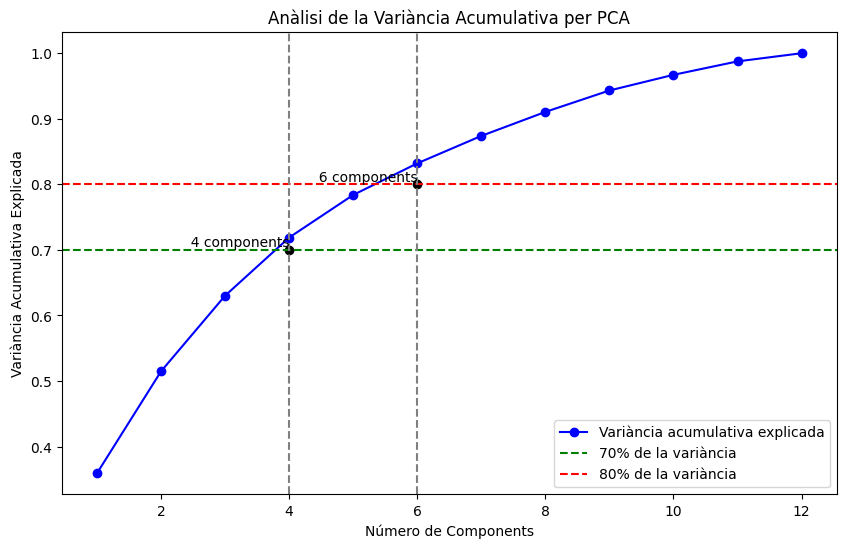

In [138]:
# Calculem la suma acumulativa de la variància explicada
cumulative_variance = np.cumsum(variance_ratio)

# Trobem el nombre de components necessaris per explicar almenys el 70-80% de la variància total
desired_variance = [0.70, 0.80]  # 70% a 80% de la variància total
components_needed = {threshold: np.argmax(
    cumulative_variance >= threshold) + 1 for threshold in desired_variance}

# Creem la gràfica
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variance_ratio)+1), cumulative_variance,
         marker='o', color='blue', label='Variància acumulativa explicada')
plt.axhline(y=0.70, color='green', linestyle='--', label='70% de la variància')
plt.axhline(y=0.80, color='red', linestyle='--', label='80% de la variància')

# Afegim punts d'interès per al 70% i 80% de la variància explicada
for threshold, components in components_needed.items():
    plt.axvline(x=components, color='grey', linestyle='--')
    plt.scatter(components, threshold, color='black')
    plt.text(components, threshold, f'  {components} components',
             verticalalignment='bottom', horizontalalignment='right')

plt.title('Anàlisi de la Variància Acumulativa per PCA')
plt.xlabel('Número de Components')
plt.ylabel('Variància Acumulativa Explicada')
plt.legend()
plt.show()

### Ultima consideració

In [139]:
X_train_norm_est.drop(columns='Sex_M', inplace=True)
X_test_norm_est.drop(columns='Sex_M', inplace=True)



In [140]:
# Convertir 'Sex' a valors numèrics: 1 per a 'F' i 0 per a 'M'
X_train_balanced['Sex'] = X_train_balanced['Sex'].replace({'F': 1, 'M': 0})

X_train_balanced
# Canviar el nom de la columna de 'Sex' a 'Sex_F'
X_train_balanced = X_train_balanced.rename(columns={'Sex': 'Sex_F'})

In [141]:
X_train_balanced

,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Physical_Symptoms_Score,Sex_F,Edema
0,64.000000,1.100000,340.770000,3.490000,52.560000,1603.140000,111.398600,120.300000,166.000000,9.800000,3.000000,0.87000,1,N
1,53.916496,3.200000,201.000000,3.110000,178.000000,1212.000000,159.650000,69.000000,188.000000,11.800000,4.000000,2.00000,1,N
2,58.817248,3.200000,260.000000,3.190000,91.000000,815.000000,127.100000,101.000000,160.000000,12.000000,4.000000,2.00000,1,N
3,52.183436,2.700000,274.000000,3.150000,159.000000,1533.000000,117.800000,128.000000,224.000000,10.500000,4.000000,1.00000,1,N
4,78.439425,7.100000,243.000000,3.030000,380.000000,983.000000,158.100000,154.000000,97.000000,11.200000,4.000000,3.00000,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,67.219168,4.580941,345.039265,3.663024,78.801194,2171.642958,107.372799,158.064056,222.348326,11.401242,4.000000,1.50973,1,S
467,53.464653,3.964714,197.628461,3.444436,80.484507,2493.906819,132.916348,141.434877,213.615025,11.310857,4.000000,1.00570,0,N
468,49.057504,4.920039,287.909389,2.717262,163.702614,7146.580180,143.640313,142.913844,115.702614,11.377154,4.000000,2.00000,1,N
469,35.229707,8.201864,624.969699,3.606970,74.463871,1811.864805,151.900000,192.051280,310.727274,10.865268,3.347319,0.67366,0,N


# MODEL

In [142]:


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    color=cmap(idx),
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')

In [143]:
import numpy as np


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Mapeig de les etiquetes categòriques a números
    unique_labels = np.unique(y)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_mapped = np.array([label_mapping[label] for label in y])

    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(unique_labels)])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, label in enumerate(unique_labels):
        plt.scatter(x=X[y_mapped == label_mapping[label], 0],
                    y=X[y_mapped == label_mapping[label], 1],
                    alpha=0.8,
                    color=cmap(idx),
                    marker=markers[idx],
                    label=label,
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

## KNN

### Hyperparameters

In [144]:

# Configurar el clasificador KNN
knn = KNeighborsClassifier()

# Crear un diccionario de todos los valores que queremos probar
param_grid = {
    'n_neighbors': np.arange(6, 20),
    'weights': ['uniform'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Usar F1 Score como métrica de rendimiento
f1_scorer = make_scorer(f1_score, average='weighted')

# Utilitzar una validació creuada estratificada
cv = StratifiedKFold(n_splits=5)

# Configurar la búsqueda en malla con validación cruzada
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring=f1_scorer, verbose=1)

# Ajustar el modelo
# Asegúrate de que X_train_norm_est y y_train_balanced estén definidos
grid_search.fit(X_train_norm_est, y_train_balanced)

# Crear un DataFrame con los resultados
df_resultados1 = pd.DataFrame(grid_search.cv_results_['params'])
df_resultados1['F1_Score'] = grid_search.cv_results_['mean_test_score']

# Ordenar el DataFrame por F1 Score de mayor a menor
df_resultados_ordenados = df_resultados1.sort_values(by='F1_Score', ascending=False)

# Visualizar el DataFrame ordenado 
df_resultados_ordenados

Fitting 5 folds for each of 126 candidates, totalling 630 fits


,algorithm,metric,n_neighbors,weights,F1_Score
0,ball_tree,euclidean,6,uniform,0.709684
42,kd_tree,euclidean,6,uniform,0.709684
70,kd_tree,minkowski,6,uniform,0.709684
28,ball_tree,minkowski,6,uniform,0.709684
84,brute,euclidean,6,uniform,0.709684
...,...,...,...,...,...
55,kd_tree,euclidean,19,uniform,0.603494
41,ball_tree,minkowski,19,uniform,0.603494
97,brute,euclidean,19,uniform,0.603494
83,kd_tree,minkowski,19,uniform,0.603494


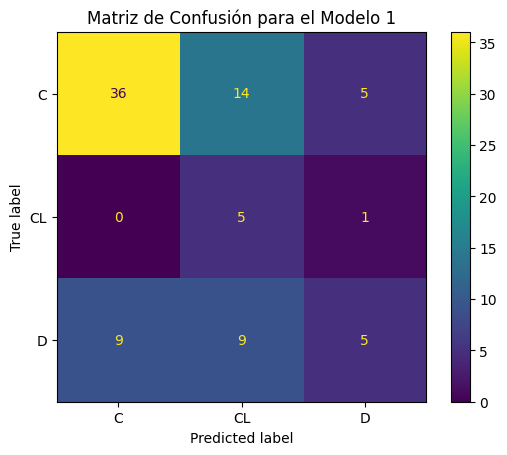

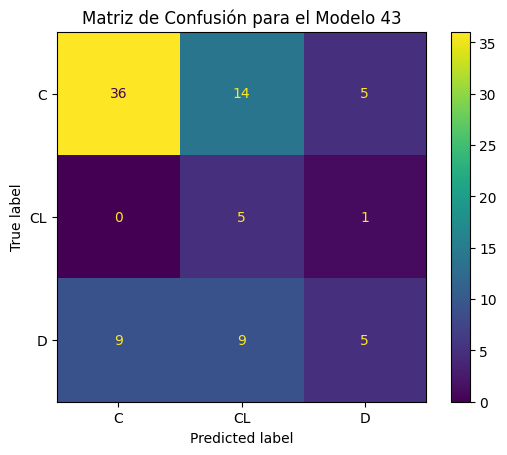

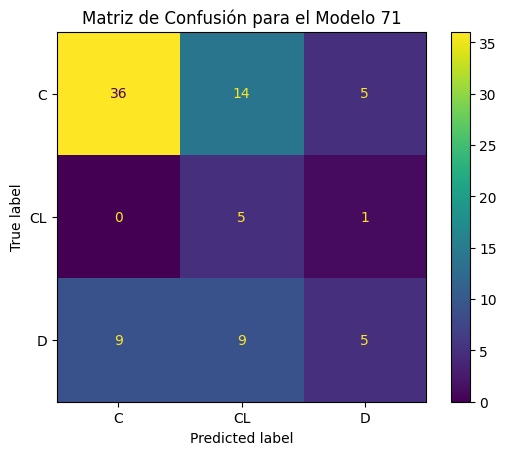

In [145]:


# Asumiendo que df_resultados_ordenados ya está definido y ordenado
# Seleccionar los tres mejores modelos
mejores_modelos = df_resultados_ordenados.head(3)

for index, modelo in mejores_modelos.iterrows():
    # Configurar KNN con los parámetros del modelo
    knn_mejor = KNeighborsClassifier(n_neighbors=modelo['n_neighbors'],
                                     weights=modelo['weights'],
                                     metric=modelo['metric'],
                                     algorithm=modelo['algorithm'])

    # Ajustar el modelo a los datos de entrenamiento
    knn_mejor.fit(X_train_norm_est, y_train_balanced)

    # Realizar predicciones en el conjunto de pruebas
    predicciones = knn_mejor.predict(X_test_norm_est)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, predicciones)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=knn_mejor.classes_)

    # Visualizar la matriz de confusión
    disp.plot()
    plt.title(f"Matriz de Confusión para el Modelo {index+1}")
    plt.show()

### Results/Evaluation

## Arbre de decisions

### Hyperparameters

In [146]:


# Definir els hiperparàmetres a provar
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

# Crear un objecte DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Definir el Grid Search amb Accuracy Score com a mètrica d'avaluació
grid_search = GridSearchCV(
    dtc, param_grid, scoring=f1_scorer, cv=cv, verbose=1)

# Ajustar el model amb les dades d'entrenament
grid_search.fit(X_train_norm_est, y_train_balanced)

# Crear un DataFrame amb els resultats
df_resultats = pd.DataFrame(grid_search.cv_results_['params'])
df_resultats['F1_Score'] = grid_search.cv_results_['mean_test_score']

# Ordenar el DataFrame per Accuracy Score de major a menor
df_resultats_ordenats2 = df_resultats.sort_values(
    by='F1_Score', ascending=False)

# Visualitzar el DataFrame ordenat
df_resultats_ordenats2

Fitting 5 folds for each of 180 candidates, totalling 900 fits


,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,F1_Score
126,entropy,10.0,sqrt,1,2,0.775735
155,entropy,15.0,log2,1,10,0.749340
171,entropy,NaN,log2,1,2,0.749121
153,entropy,15.0,log2,1,2,0.735028
130,entropy,10.0,sqrt,5,5,0.733728
...,...,...,...,...,...,...
3,gini,3.0,sqrt,5,2,0.571404
5,gini,3.0,sqrt,5,10,0.571107
102,entropy,3.0,log2,5,2,0.568291
1,gini,3.0,sqrt,1,5,0.562776


### Results/Evaluation

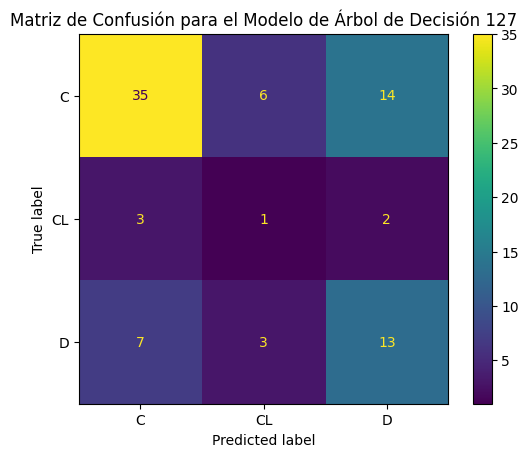

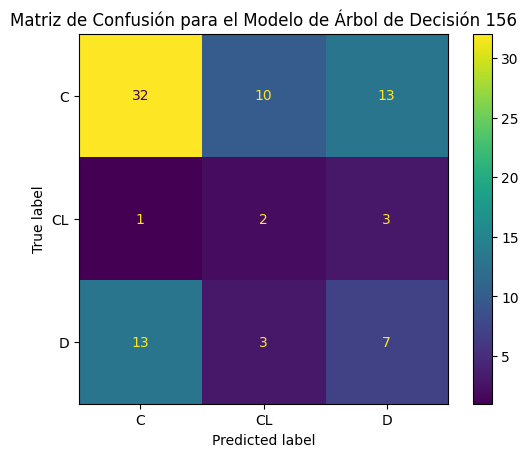

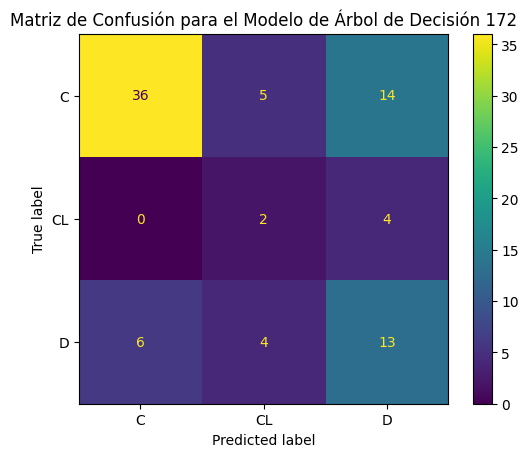

In [151]:
# Asumiendo que df_resultats_ordenats2 ya está definido y ordenado
# Seleccionar los tres mejores modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
mejores_modelos_des = df_resultats_ordenats2.head(3)

for index, modelo in mejores_modelos_des.iterrows():
    # Convertir 'max_depth' a entero si no es None
    max_depth = int(modelo['max_depth']) if pd.notna(modelo['max_depth']) else None

    # Configurar DecisionTreeClassifier con los parámetros del modelo
    dtc_mejor = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=int(modelo['min_samples_split']),
        min_samples_leaf=int(modelo['min_samples_leaf']),
        criterion=modelo['criterion'],
        max_features=modelo['max_features']
    )

    # Ajustar el modelo a los datos de entrenamiento
    dtc_mejor.fit(X_train_norm_est, y_train_balanced)

    # Realizar predicciones en el conjunto de pruebas
    predicciones_dtc = dtc_mejor.predict(X_test_norm_est)

    # Calcular la matriz de confusión
    cm_dtc = confusion_matrix(y_test, predicciones_dtc)
    disp_dtc = ConfusionMatrixDisplay(
        confusion_matrix=cm_dtc, display_labels=dtc_mejor.classes_)

    # Visualizar la matriz de confusión
    disp_dtc.plot()
    plt.title(
        f"Matriz de Confusión para el Modelo de Árbol de Decisión {index + 1}")
    plt.show()

## SVM

### Hyperparameters

In [152]:



# Definir los hiperparámetros a probar
param_grid = {
    'C':  np.arange(1, 20),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 0.1, 1],
    'degree': [1, 3, 4]  # Solo se aplicará con el kernel 'poly'
}

# Crear un objeto SVM
svm = SVC()

# Usar F1 Score como métrica de rendimiento
f1_scorer = make_scorer(f1_score, average='weighted')

# Utilizar una validación cruzada estratificada con una semilla fija
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=45)

# Definir el Grid Search con F1 Score como métrica de evaluación
grid_search = GridSearchCV(
    svm, param_grid, scoring=f1_scorer, cv=cv, verbose=1)

# Ajustar el modelo con los datos de entrenamiento
# Asegúrate de que X_train_norm_est y y_train_balanced estén definidos
grid_search.fit(X_train_norm_est, y_train_balanced)

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(grid_search.cv_results_['params'])
df_resultados['F1_Score'] = grid_search.cv_results_['mean_test_score']

# Ordenar el DataFrame por F1 Score de mayor a menor
df_resultats_ordenats3 = df_resultados.sort_values(
    by='F1_Score', ascending=False)

# Visualizar el DataFrame ordenado
df_resultats_ordenats3

Fitting 5 folds for each of 513 candidates, totalling 2565 fits


,C,degree,gamma,kernel,F1_Score
169,7,1,1,rbf,0.823656
178,7,3,1,rbf,0.823656
187,7,4,1,rbf,0.823656
214,8,4,1,rbf,0.820936
196,8,1,1,rbf,0.820936
...,...,...,...,...,...
104,4,4,0.1,poly,0.516833
77,3,4,0.1,poly,0.400425
14,1,3,0.1,poly,0.343474
50,2,4,0.1,poly,0.316526


### Results/Evaluation

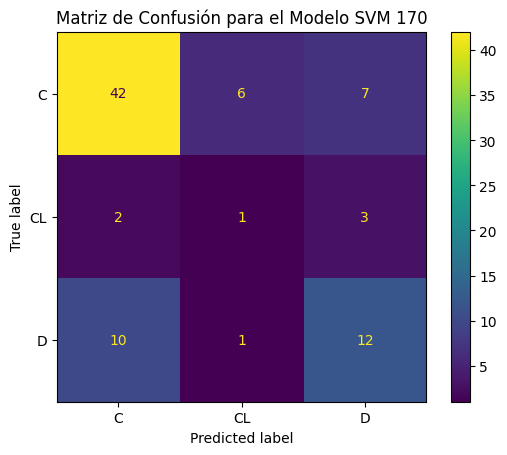

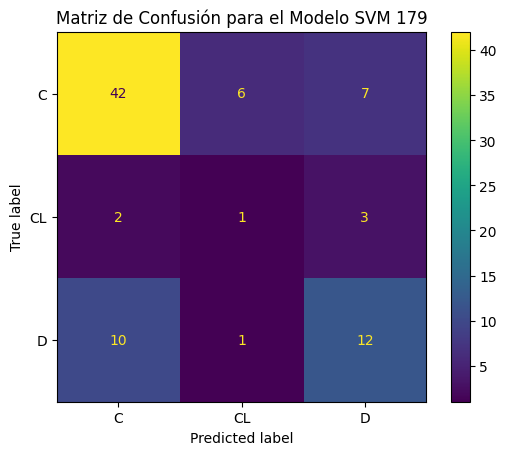

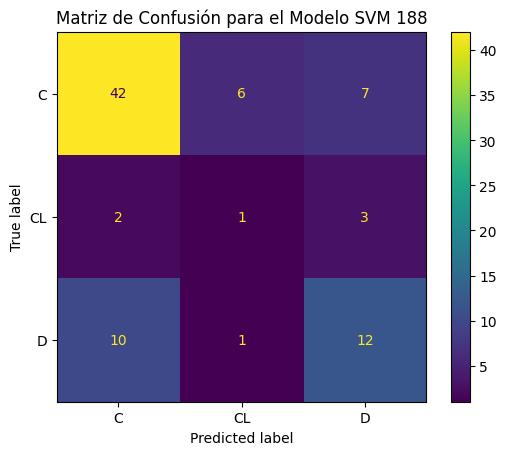

In [153]:
# Asumiendo que df_resultats_ordenats2 ya está definido y ordenado
# Seleccionar los tres mejores modelos
mejores_modelos_svm = df_resultats_ordenats3.head(3)

for index, modelo in mejores_modelos_svm.iterrows():
    # Configurar SVM con los parámetros del modelo
    svm_mejor = SVC(C=modelo['C'],
                    kernel=modelo['kernel'],
                    gamma=modelo['gamma'],
                    degree=modelo['degree'])

    # Ajustar el modelo a los datos de entrenamiento
    svm_mejor.fit(X_train_norm_est, y_train_balanced)

    # Realizar predicciones en el conjunto de pruebas
    predicciones_svm = svm_mejor.predict(X_test_norm_est)

    # Calcular la matriz de confusión
    cm_svm = confusion_matrix(y_test, predicciones_svm)
    disp_svm = ConfusionMatrixDisplay(
        confusion_matrix=cm_svm, display_labels=svm_mejor.classes_)

    # Visualizar la matriz de confusión
    disp_svm.plot()
    plt.title(f"Matriz de Confusión para el Modelo SVM {index+1}")
    plt.show()

# BONUS 2

In [154]:
X_train_norm_est_df = pd.DataFrame(X_train_norm_est)
y_train_balanced_df = y_train_balanced.to_frame()

In [155]:
pca2 = PCA()
df2_plot = pd.DataFrame(pca2.fit_transform(X_train_norm_est))
X = pd.DataFrame(scale(df2_plot), index=y_train_balanced_df.Status, columns=df2_plot.columns)

Text(0.5, 1.0, 'Single Linkage')

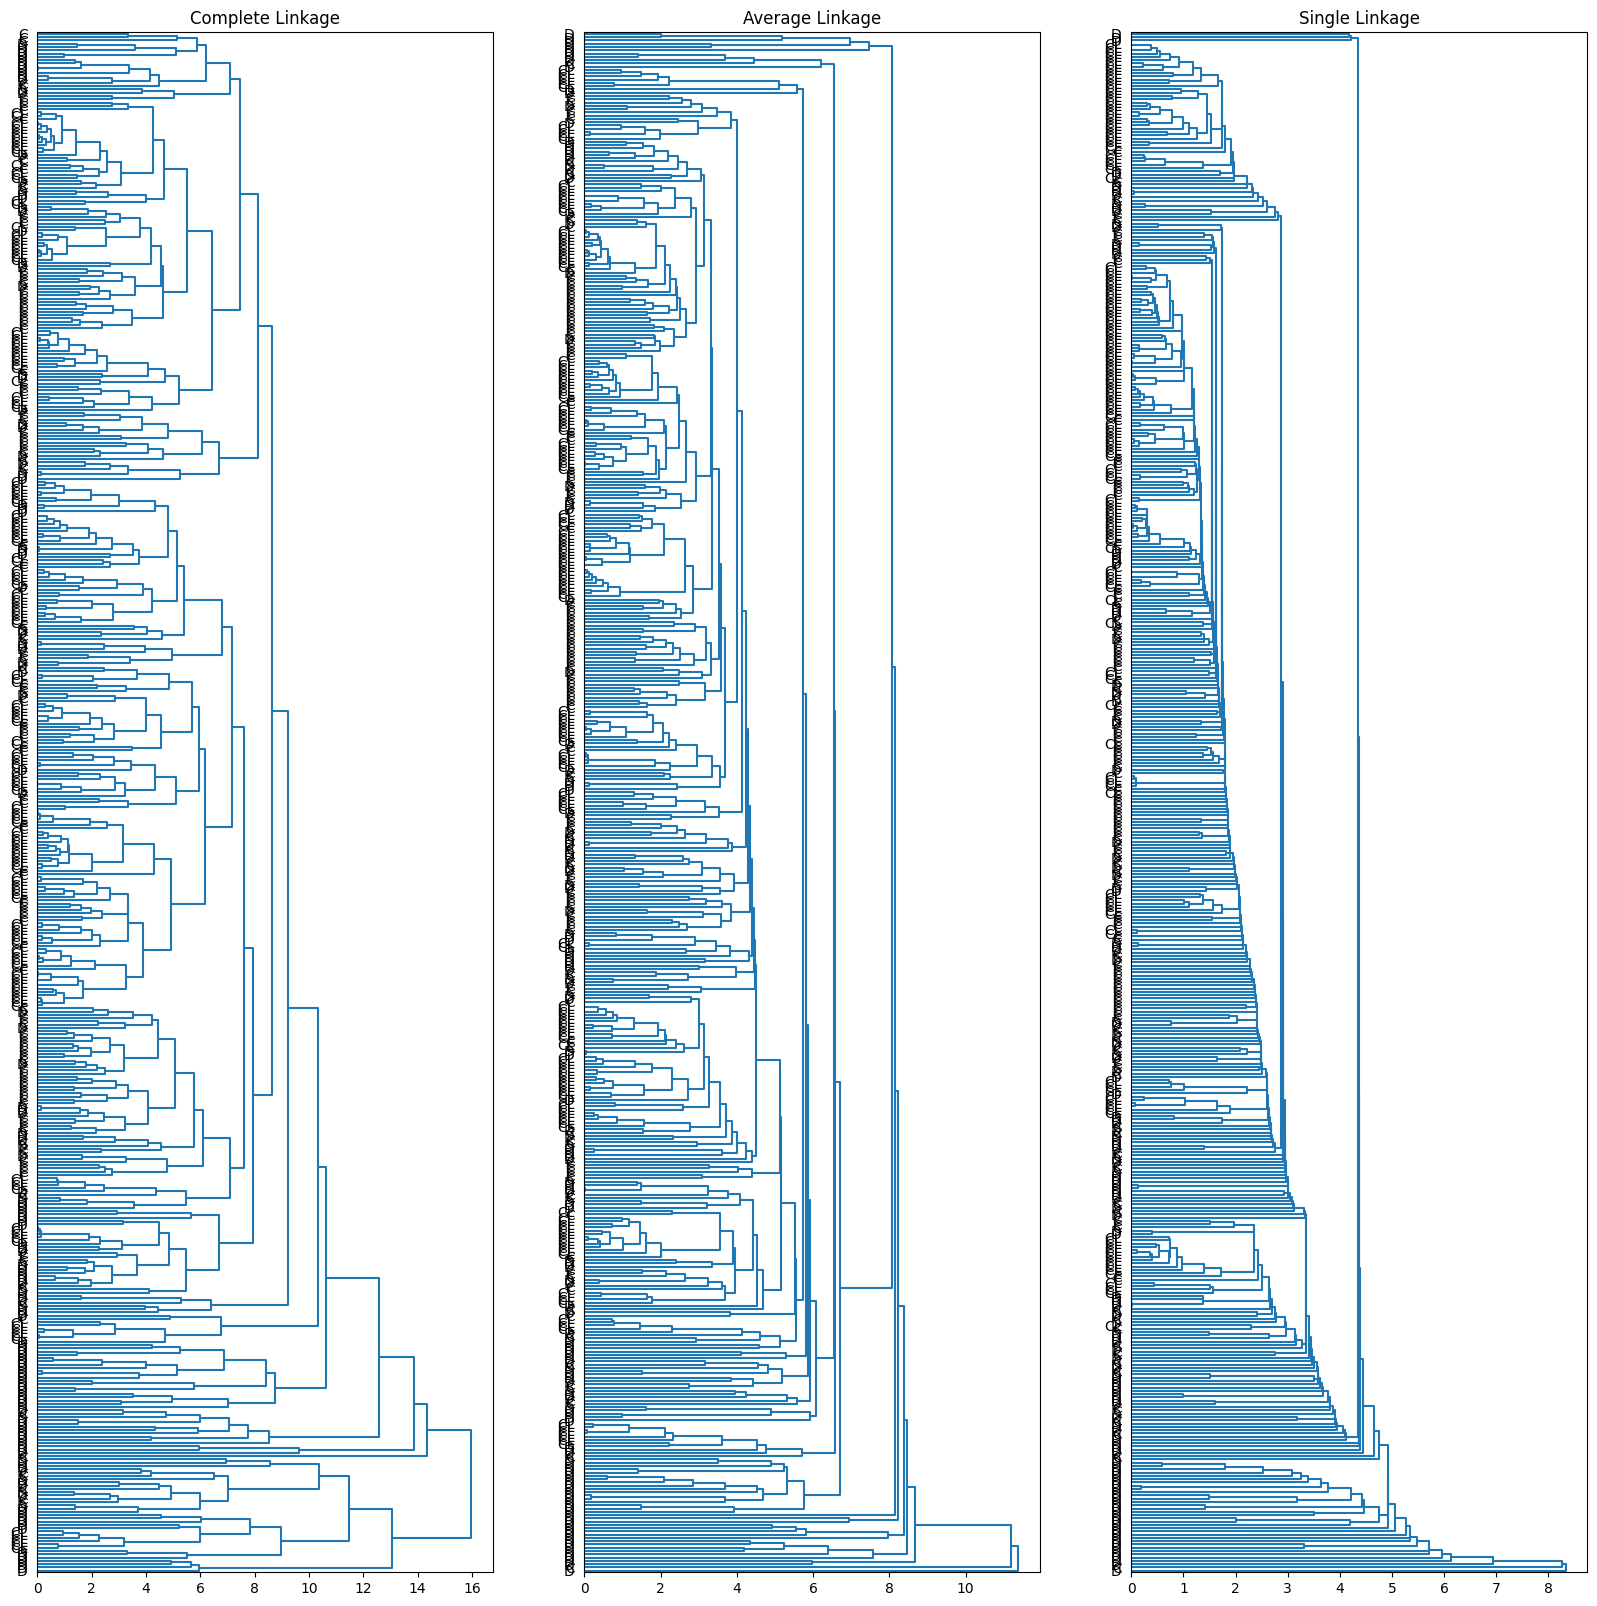

In [156]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1', 'c2', 'c3'],
                                [ax1, ax2, ax3]):
    cluster = hierarchy.dendrogram(
        linkage, labels=X.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')

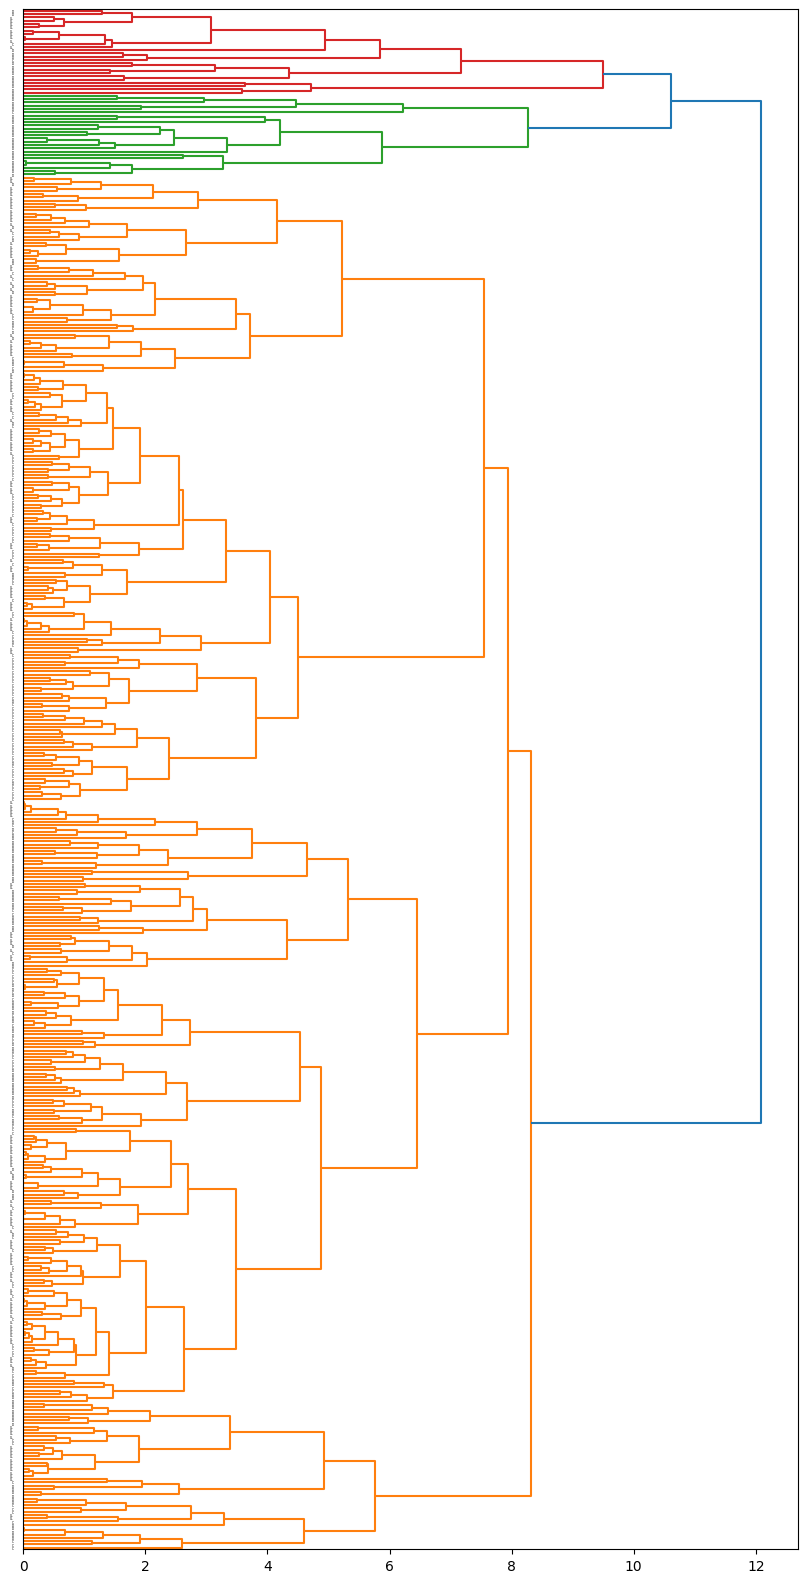

In [161]:
# Hierarchy based on Principal Components 1 to 5
plt.figure(figsize=(10, 20))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(
    df2_plot.iloc[:, :5]), labels=y_train_balanced_df.Status.values, orientation='right', color_threshold=10, leaf_font_size=2.2)

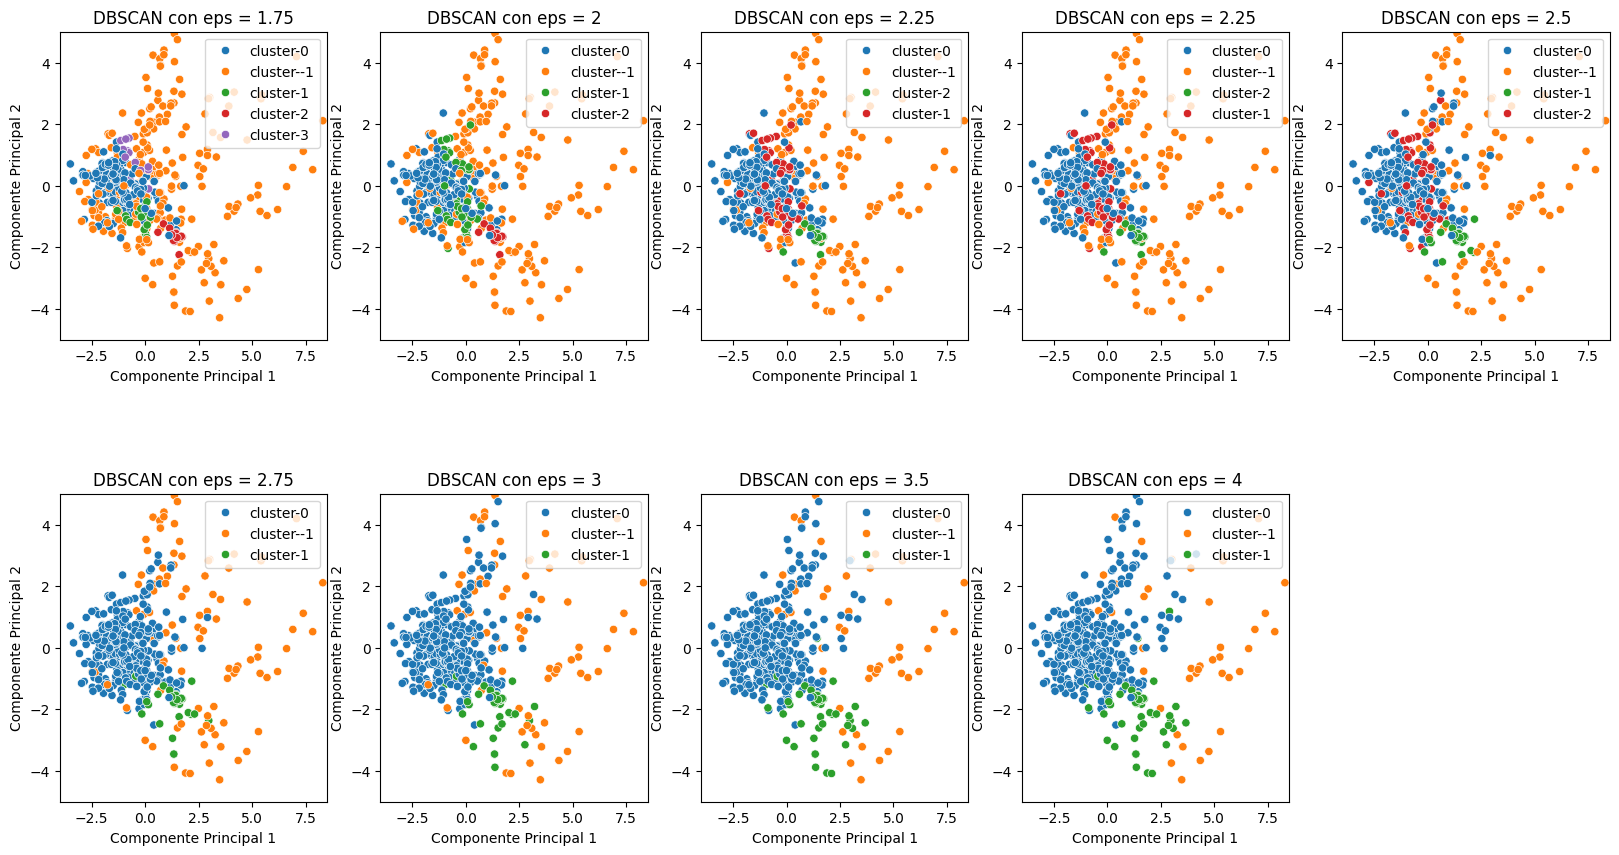

In [158]:

# Apply PCA
df2_plot = pd.DataFrame(pca2.fit_transform(scale(X_train_norm_est)))

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

# Establecer rangos comunes para todos los subplots
x_lim = (-4, 8.5)
y_lim = (-5, 5)

# Defineix aquí la llista de valors eps que vols explorar
eps_values = [1.75,2,2.25,2.25,2.5,2.75,3,3.5,4]  # Exemple de valors

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10).fit(df2_plot)
    labels = db.labels_

    ax = fig.add_subplot(2, 5, i)
    sns.scatterplot(x=df2_plot[0], y=df2_plot[1], hue=[
                    "cluster-{}".format(x) for x in labels], ax=ax)
    ax.set_title(f"DBSCAN con eps = {round(eps, 2)}", fontsize=12)
    ax.legend(loc='upper right')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')

    i += 1

plt.show()